## CD4 Naive cells Gene module Plot

In [1]:

# load libraries
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(tidyverse)
quiet_library(Seurat)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(future)
quiet_library(future.apply)
quiet_library(SingleCellExperiment)
quiet_library(SeuratDisk)
quiet_library(ggpubr)
quiet_library(knitr)
quiet_library(plotly)
quiet_library(lme4)
quiet_library(ggpubr)
quiet_library(ggrepel)
quiet_library(ggthemes)
quiet_library(GSVA)
quiet_library(tidyr)
quiet_library(SummarizedExperiment)
options(warn = -1)

In [2]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy = "multicore", workers = future::availableCores()-5)  
options(future.globals.maxSize = 1000 * 1024^3)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [3]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")
coolors_clrs<-c("#EFB0A1","#009FF5","#1A5E9B","#42E2B8","#4ECDC4","#89B6A5","#F1D26A","#D5B0AC","#EDABB1","#02504D","#AA9674","#E64B35FF","#4DBBD5FF","#00A087FF")

cluster_colors_ext <- colorRampPalette(cluster_colors)(36)
options(repr.plot.width =5, repr.plot.height =5)

In [4]:
fig_path="/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/"

In [5]:

#' # Function: run_gsva_analysis
#' # This function runs Gene Set Variation Analysis (GSVA) for pseudobulk objects with user-defined gene sets.
#' # It filters metadata, runs GSVA, and merges results with external ALTRA data for further analysis.
#'
#' @param psb_object The pseudobulk object from which expression data will be extracted.
#' @param cell_type The cell type to be analyzed.
#' @param gene_csv CSV file containing the gene list with upregulated and downregulated genes.
#' @param metadata_csv CSV file containing the metadata for samples.
#' @param altra_csv CSV file containing ALTRA cohort data for merging.
#' @param output_csv Path to save the GSVA results in CSV format.
#' @param gsva_method The GSVA method to be used, default is "gsva".
#'
#' @return A list containing the GSVA results in wide format and the filtered metadata.
#' 
#' @details 
#' This function performs GSVA on the specified cell type in the pseudobulk object, using upregulated and downregulated genes.
#' It saves the GSVA results in a CSV and also merges the metadata with ALTRA cohort data for downstream analysis.
#' The filtering steps remove male samples and limit the data to days_to_conversion >= -750.

run_gsva_analysis <- function(psb_object, cell_type, gene_csv, metadata_csv, altra_csv, output_csv, gsva_method = "gsva") {
  # Read pseudobulk object and gene list
  psb_obj <- psb_object[[cell_type]]
  act_df <- read.csv(gene_csv)
  
  # Create direction column
  #act_df$direction <- ifelse(act_df$estimate > 0, "up", "down")
  
  # Extract gene lists
  up_act_genes <- act_df$upreg_gene
  down_act_genes <- act_df$downreg_gene
  
  # Extract expression matrix from pseudobulk object
  expr_matrix <- assay(psb_obj, "vst")
  
  # Create gene set index list
  gset.idx.list <- list(
    up_act_genes = up_act_genes,
    down_act_genes = down_act_genes
  )
  
  # Run GSVA
  gsva_results <- gsva(
    expr = expr_matrix,
    gset.idx.list = gset.idx.list,
    #method = gsva_method,
    abs.ranking = FALSE
    #ssgsea.norm = TRUE
  )
  
  # Convert results to DataFrame and long format
  gsva_df <- as.data.frame(gsva_results) %>%
    rownames_to_column(var = "gene_type") %>%
    pivot_longer(cols = -gene_type, names_to = "sample.sampleKitGuid", values_to = "expression")
  
  # Convert to wide format
  df_wide <- gsva_df %>%
    pivot_wider(names_from = gene_type, values_from = expression)
  
  # Save GSVA results to CSV
  write.csv(df_wide, output_csv)
  
  # Read and filter metadata
  meta <- read.csv(metadata_csv) %>%
    filter(subject.subjectGuid != "CU1015") %>%
    filter(Status_Long %in% c("pre", "conversion")) %>%
    select(Status_Long, sample.sampleKitGuid, days_to_conversion, subject.biologicalSex, subject.subjectGuid, bmi_conv, age_conv)
  
  # Read and merge with ALTRA data
  altra <- read.csv(altra_csv) %>%
    select(sample.sampleKitGuid, s1_ids, Status_new)
  
  merged_df <- left_join(meta, altra, by = "sample.sampleKitGuid") %>%
    filter(days_to_conversion >= -750) %>%
    filter(subject.biologicalSex != "Male") %>%
    drop_na()
  
  return(list(gsva_results = df_wide, merged_metadata = merged_df))
}



In [6]:
#' # Example usage of PlotFreqLinePlot function
#' # This function plots frequency line plots with model predictions.
#' PlotFreqLinePlot1(frequency_table, model_fit, palette, fig_path = "path/to/save", fig_name = "fig_name",
#'                  x_var = "days_to_conversion", y_var = "clr", color_var = "subject.subjectGuid",
#'                  shape_var = "sex", title = "Cluster 9", x_label = "Days to Conversion", 
#'                  y_label = "CLR", annotation_text = "p=0.055", annotation_x = -600, 
#'                  annotation_y = 1, annotation_color = "red")
#'
#' @export
#' @param frequency_table The input data frame containing frequency values to plot.
#' @param model_fit A fitted model object for predictions.
#' @param palette A color palette for the plot.
#' @param fig_path The file path where the plot will be saved (optional).
#' @param fig_name The name of the file where the plot will be saved (optional).
#' @param x_var The variable for the x-axis (default is "days_to_conversion").
#' @param y_var The variable for the y-axis (default is "clr").
#' @param color_var The variable to determine line colors (default is "subject.subjectGuid").
#' @param shape_var The variable to determine point shapes (default is "sex").
#' @param title The title of the plot.
#' @param x_label The x-axis label (default is "Days to Conversion").
#' @param y_label The y-axis label (default is "CLR").
#' @param annotation_text Text for annotation on the plot.
#' @param annotation_x X coordinate for the annotation.
#' @param annotation_y Y coordinate for the annotation.
#' @param annotation_color Color of the annotation text.


PlotFreqLinePlot1 <- function(frequency_table, model_fit, palette, fig_path = NULL, fig_name = NULL,
                             x_var = "days_to_conversion", y_var = "clr", color_var = "subject.subjectGuid",
                             shape_var = "sex", title = "Cluster 9", x_label = "Days to Conversion", 
                             y_label = "CLR", 
                              #annotation_text = "padj=", 
                              annotation_x = -600, 
                             annotation_y = 1, annotation_color = "red", x_limits = NULL, y_limits = NULL) {
    require(ggplot2)
    require(ggeffects)

    # Extract the prediction data frame
    pred.mm <- ggpredict(model_fit, terms = c(x_var))  # Adjusted to use x_var

    # plot
    p1 <- frequency_table %>%
        ggplot() +
        geom_line(aes(x = .data[[x_var]], y = .data[[y_var]], color = .data[[color_var]]), size = 1) + 
        geom_point(aes(x = .data[[x_var]], y = .data[[y_var]], shape = .data[[shape_var]])) + 
        geom_line(data = pred.mm, aes(x = x, y = predicted), color = "#8F7700FF", size = 2) +          
        geom_ribbon(data = pred.mm, aes(x = x, ymin = predicted - 3 * std.error, ymax = predicted + 3 * std.error), 
                    fill = "#8F7700FF", alpha = 0.3) + 
        #annotate(geom = "text", x = annotation_x, y = annotation_y, label = annotation_text, size = 6,
                # color = annotation_color) +
        labs(title = title) + 
        xlab(x_label) +  
        ylab(y_label) +
        scale_color_manual(values = palette) + 
        theme_few()+
        theme(
            text = element_text(size = 10, face = "bold"),  
            axis.title = element_text(size = 10, face = "bold"),  
            axis.text = element_text(size = 10, face = "bold"),  
            plot.title = element_text(size = 10, face = "bold"),  
            legend.position = "none",  # Remove all legends
            panel.grid.minor = element_blank(),
            panel.grid.major = element_blank(),
            panel.background = element_blank()
        ) +
        scale_shape_manual(values = c(1, 2))  # No need for guides() here

    # Adjust the scale of x and y axes if limits are provided
    if (!is.null(x_limits)) {
        p1 <- p1 + scale_x_continuous(limits = x_limits)
    }
    if (!is.null(y_limits)) {
        p1 <- p1 + scale_y_continuous(limits = y_limits)
    }

    # Code to save the plot if fig_path and fig_name are provided
    if (!missing(fig_path) && !missing(fig_name) && nzchar(fig_path) && nzchar(fig_name)) {
        # Construct the full file path with the figure name and desired file extension
        file_name <- paste0(fig_path, "/", fig_name)
        # Use ggsave to save the plot
        ggsave(file_name, plot = p1, width = 4, height = 4, dpi = 300)
    }
    return(p1)
}


In [7]:
#reading the psb object
a3_psb=readRDS("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/input_files/Zi_pseudobulk obj/cache/710ae367-e37a-44f3-8e50-9b8d7c76a439/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3__deseq2_norm_counts_list.rds")

In [8]:
# Example of how to use the function
result <- run_gsva_analysis(
  psb_object = a3_psb,
  cell_type = "Core naive CD4 T cell",
  gene_csv = "/home/jupyter/ALTRA_ANALYSIS/Deep_clean/certpro/input_files/CSV_input_files/ALTRA_AIM3_certpro_scRNA_Pseudobulk_AIFI_l3_mixed_models_time_result_750days - FINAL COMBINED Activation Signature.csv",
  metadata_csv = "/home/jupyter/ALTRA_ANALYSIS/Deep_clean/AIM3/input_csv_files/2023-11-22_ALTRA_Metadata_labs.csv",
  altra_csv = "/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/certpro_Zi_files/Figure_input_files/ALTRA_Fig1_Master_meta
                    .csv",
  output_csv = "/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/outputfiles/ALTRA_CD4_naive_gsva_up_down_gene_module_scores.csv"
)

# Access the results
gsva_results_df <- result$gsva_results
filtered_metadata_df <- result$merged_metadata


Estimating GSVA scores for 2 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [9]:
# Access the results
gsva_results_df <- result$gsva_results
filtered_metadata_df <- result$merged_metadata

In [10]:
filtered_metadata_df%>%head()
gsva_results_df%>%head()

,Status_Long,sample.sampleKitGuid,days_to_conversion,subject.biologicalSex,subject.subjectGuid,bmi_conv,age_conv,s1_ids,Status_new
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>
1,pre,KT00052,-714,Female,CU1009,25.64892,58,ARI36,LONG
2,pre,KT00056,-632,Female,CU1007,26.19498,44,ARI46,LONG
3,pre,KT00057,-615,Female,CU1003,23.14306,23,ARI35,LONG
4,pre,KT00082,-540,Female,CU1007,26.19498,44,ARI46,LONG
5,pre,KT00084,-614,Female,CU1029,28.67547,66,ARI37,LONG
6,pre,KT00099,-516,Female,CU1003,23.14306,23,ARI35,LONG


sample.sampleKitGuid,up_act_genes,down_act_genes
<chr>,<dbl>,<dbl>
KT00052,-0.6408788,0.5916294
KT00056,-0.3706911,0.5172875
KT00057,-0.4028328,0.5691330
KT00082,-0.1558945,0.2479784
KT00084,0.5256763,-0.2840878
KT00099,-0.2059244,0.3431546


In [11]:
mdf=left_join(filtered_metadata_df,gsva_results_df,by="sample.sampleKitGuid")
mdf%>%dim
mdf%>%head(3)

[1] 58 11

,Status_Long,sample.sampleKitGuid,days_to_conversion,subject.biologicalSex,subject.subjectGuid,bmi_conv,age_conv,s1_ids,Status_new,up_act_genes,down_act_genes
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,pre,KT00052,-714,Female,CU1009,25.64892,58,ARI36,LONG,-0.6408788,0.5916294
2,pre,KT00056,-632,Female,CU1007,26.19498,44,ARI46,LONG,-0.3706911,0.5172875
3,pre,KT00057,-615,Female,CU1003,23.14306,23,ARI35,LONG,-0.4028328,0.5691330


In [12]:
# removing NA
mdf2=mdf%>%drop_na()
mdf2%>%dim
mdf2%>%head(3)

[1] 50 11

,Status_Long,sample.sampleKitGuid,days_to_conversion,subject.biologicalSex,subject.subjectGuid,bmi_conv,age_conv,s1_ids,Status_new,up_act_genes,down_act_genes
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,pre,KT00052,-714,Female,CU1009,25.64892,58,ARI36,LONG,-0.6408788,0.5916294
2,pre,KT00056,-632,Female,CU1007,26.19498,44,ARI46,LONG,-0.3706911,0.5172875
3,pre,KT00057,-615,Female,CU1003,23.14306,23,ARI35,LONG,-0.4028328,0.5691330


In [13]:
 # Fit the linear mixed-effects model
up_genes_model <- lmerTest::lmer(up_act_genes ~ age_conv + bmi_conv + days_to_conversion + (1 | subject.subjectGuid), data = mdf2)

Loading required package: ggeffects



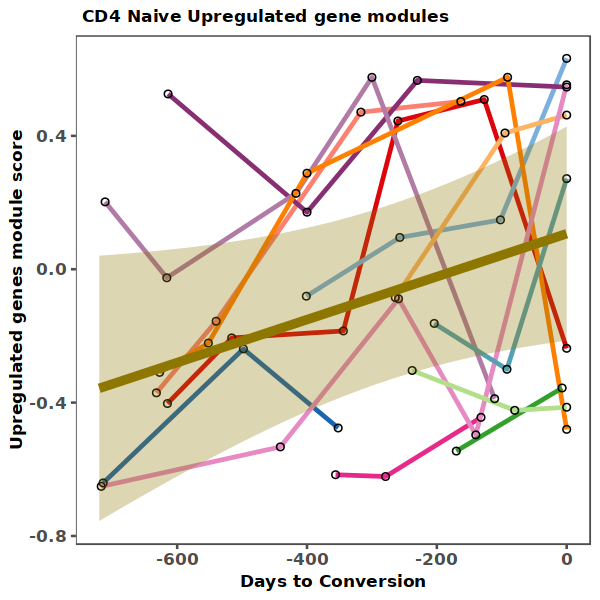

In [14]:
options(repr.plot.width =5, repr.plot.height =5)
PlotFreqLinePlot1(mdf2 %>% mutate(Sex=subject.biologicalSex), model_fit=up_genes_model, palette=cluster_colors,
                 fig_path = fig_path,fig_name ="Fig_5C.pdf",
                  x_var = "days_to_conversion", y_var = "up_act_genes", color_var = "subject.subjectGuid",
                  shape_var = "Sex", title = " CD4 Naive Upregulated gene modules", x_label = "Days to Conversion", 
                  y_label = "Upregulated genes module score", 
                 #annotation_text = "pval=0.006", 
                # y_limits=c(-1,1),
                 annotation_x = -600, 
                  annotation_y =1.7, 
                  annotation_color = "black")

In [15]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/libs/r_scrna/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggeffects_1.7.0             GSVA_1.48.3                
 [3] ggthemes_5.1.0              ggrepel_0.9.5              
 [5] lme4_1.1-34                 plotly_4.10.4              
 [7] knitr_1.47                  ggpubr_0.6.0               
 [9] SeuratDisk_0.0.0.9021       Single